# Project 3

The goal of this project is to Compare differnt Rnn models to determine which is the fastest or most accurate at basic stock prediction. This will be accomplished by using Amazon stock history to create a model that will determine if a stock has gone up in price or down in price. It is thus a binary classifier. 

Once the fastest model has been chosen then I will attmept to do a price prediction with that model.

In [233]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as pdta
import tqdm
import json
import os
import shutil
import zipfile
import os
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)


Num GPUs Available:  0


2022-12-11 13:29:28.767366: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-11 13:29:28.767797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:695] could not allocate CUDA stream for context 0x764c190: CUDA_ERROR_UNKNOWN: unknown error
2022-12-11 13:29:28.767833: E tensorflow/compiler/xla/stream_executor/stream.cc:297] failed to allocate stream during initialization
2022-12-11 13:29:28.768018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:695] could not allocate CUDA stream for context 0x764c190: CUDA_ERROR_UNKNOWN: unknown error
2022-12-11 13:29:28.768044: E tensorflow/compiler/xla/stream_executor/stream.cc:297] failed to allocate str

# Data Processing

Start by downloading 32 years worth of data from yahoo finance

In [234]:
df = yf.download(tickers='AMZN',start = '1990-01-01', end= '2022-12-07')
display(df)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...
2022-11-30,92.470001,96.540001,91.529999,96.540001,96.540001,102628200
2022-12-01,96.989998,97.230003,94.919998,95.500000,95.500000,68488000
2022-12-02,94.480003,95.360001,93.779999,94.129997,94.129997,72427000


Alright so after loading the history of Amazons stocks in to the dataframe we have a bunch of columns. At first glance the data column is not gonna be needed. the other columns on the other hand all have useful data to them. However the Volumn column is going to be dropped. While it is useful to know how many stocks were sold in a day, these numbers appear to be wrong. Even if they are not wrong they are so large that if included them in the model everything else would look like zero so it would make the dataset almost useless. therefore the volumn and the data column will be dropped. The adjusted close will also be droped as it looks like a duplicate of the close price. I will also be adding some technical indicators that are typicall helpful when doing these kind of predictions. These indicator are the relative strength index which will be a measure of how much stocks gain or lose the standard period is around 14 days, the next few columns will be some Exponential moving averages of different lengths to represent different trends in stocks. these extra data points should be invaluable to the models over all accuracy. The averages typically have 10,50 and 200 day averages so that is what I will be doing here. These momentum indicators will be based on the close prices

In [235]:
#adding new columns and doing the math with pandas_ta
df["RSI"] = pdta.rsi(df['Close'], length=14)
df['EMA_s'] = pdta.ema(df['Close'], length=10)
df['EMA_m'] = pdta.ema(df['Close'], length=50)
df['EMA_l'] = pdta.ema(df['Close'], length=200)

#now we need to make out label so to do this we need to know if a stocks
#price has gone up or down so we will be making a change column using the close data
#we then need to shift this down one so that the next day will have the change this is done by the shift(-1)

df['Change'] = df['Adj Close']-df['Open']
df['Change'] = df["Change"].shift(-1)

#now using the change we can make our label

df["Up/Down"] = [1 if df['Change'][i]>0 else 0 for i in range(len(df))]


df['NextDayAdjClose'] = df["Adj Close"].shift(-1)
df = df.dropna()
df = df.drop(columns=['Volume' ,'Close'])
display(df)


,Open,High,Low,Adj Close,RSI,EMA_s,EMA_m,EMA_l,Change,Up/Down,NextDayAdjClose
Date,,,,,,,,,,,
1998-03-02,0.316146,0.321875,0.312500,0.317708,76.957593,0.287125,0.253435,0.175827,-0.015625,0,0.298958
1998-03-03,0.314583,0.315625,0.297917,0.298958,64.204877,0.289276,0.255220,0.177052,0.005990,1,0.305990
1998-03-04,0.300000,0.309375,0.291667,0.305990,66.450323,0.292315,0.257211,0.178335,0.013542,1,0.312500
1998-03-05,0.298958,0.325781,0.296875,0.312500,68.425050,0.295985,0.259379,0.179670,0.004688,1,0.319792
1998-03-06,0.315104,0.320833,0.307292,0.319792,70.518307,0.300314,0.261748,0.181064,0.027604,1,0.347917
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-29,94.040001,94.410004,91.440002,92.419998,38.539036,94.160898,105.071174,124.659814,4.070000,1,96.540001
2022-11-30,92.470001,96.540001,91.529999,96.540001,46.409553,94.593463,104.736618,124.380015,-1.489998,0,95.500000
2022-12-01,96.989998,97.230003,94.919998,95.500000,44.848309,94.758288,104.374398,124.092652,-0.350006,0,94.129997


Next we need to scale the data to be between 0 and 1, we also want to save the converstion number used to conver the data for later.

In [236]:
# copy the data
df_max_scaled = df.copy()
conversionMax = df['NextDayAdjClose'].abs().max()
print(conversionMax)
# apply normalization techniques
for column in df_max_scaled.columns:
    
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
      
# view normalized data
display(df_max_scaled)
print(0.001602*conversionMax)

186.57049560546875


,Open,High,Low,Adj Close,RSI,EMA_s,EMA_m,EMA_l,Change,Up/Down,NextDayAdjClose
Date,,,,,,,,,,,
1998-03-02,0.001689,0.001706,0.001691,0.001703,0.816837,0.001579,0.001449,0.001048,-0.001356,0.0,0.001602
1998-03-03,0.001680,0.001673,0.001612,0.001602,0.681478,0.001591,0.001460,0.001055,0.000520,1.0,0.001640
1998-03-04,0.001603,0.001640,0.001578,0.001640,0.705312,0.001608,0.001471,0.001063,0.001175,1.0,0.001675
1998-03-05,0.001597,0.001727,0.001606,0.001675,0.726272,0.001628,0.001483,0.001071,0.000407,1.0,0.001714
1998-03-06,0.001683,0.001701,0.001662,0.001714,0.748490,0.001652,0.001497,0.001079,0.002396,1.0,0.001865
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-29,0.502350,0.500440,0.494699,0.495362,0.409058,0.517820,0.600911,0.742765,0.353283,1.0,0.517445
2022-11-30,0.493964,0.511730,0.495186,0.517445,0.492596,0.520199,0.598997,0.741098,-0.129334,0.0,0.511871
2022-12-01,0.518109,0.515388,0.513527,0.511871,0.476025,0.521105,0.596926,0.739386,-0.030381,0.0,0.504528


0.29888593395996094


Next we will group the x data by the number of days we want to feed in at a time, and grab the y values that each time segment coresponds to.

In [238]:
numpy_scaled = df_max_scaled.to_numpy()

x_data =[]

numDays = 30 #this is the number of days feed in before a prediction

print(numpy_scaled.shape)
for x in range(8): #want to keep the first 8 columns for the data
    x_data.append([])
    for y in range(numDays, numpy_scaled.shape[0]):
        x_data[x].append(numpy_scaled[y-numDays:y,x])

x_data = np.moveaxis(x_data, [0],[2])

x_data, y = np.array(x_data), np.array(numpy_scaled[numDays:,-1])
y=np.reshape(y,(len(y),1))
print(x_data.shape,"\n",y.shape)





(6234, 11)
(6204, 30, 8) 
 (6204, 1)


Code on how to spilt the data

In [239]:
# print(6204*.6)
# print(6234-3740)
# print(3740*.5)
print(x_data.shape[0])
big=int(x_data.shape[0]*.6)
remain = int(x_data.shape[0]-big)
half= int(remain*.5)
print(int(big))



6204
3722


Splitting the data

In [240]:
trainX, valX, testX = x_data[:big], x_data[big:(big+half)], x_data[(big+half):]
trainY, valY, testY = y[:big], y[big:(big+half)], y[(big+half):]

print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)

(3722, 30, 8) (1241, 30, 8) (1241, 30, 8)
(3722, 1) (1241, 1) (1241, 1)


## Benchmark

I started with the lstm as a simple benchmark to compare all of the models, as I figured that being the intial inpuys wont effect the model as much that this would be the best model to use


## Training and tuning the model

The modelwas rather large to keep copying and pasting so after a few runs it was dtermined tha the initial learning rate of 0.001 was they best  and being the goal was to comparte models not much else was done However the data itself was rather intersting.

In [241]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(LSTM(150, name="layer1"))
model.add(Dense(1))
model.add(Activation('linear'))



In [242]:
opt=Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 150)               95400     
                                                                 
 dense_21 (Dense)            (None, 1)                 151       
                                                                 
 activation_21 (Activation)  (None, 1)                 0         
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [243]:
H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

Epoch 1/30
249/249 [==============================] - 4s 12ms/step - loss: 4.0354e-05 - accuracy: 0.0000e+00 - val_loss: 2.8437e-05 - val_accuracy: 0.0000e+00
Epoch 2/30
249/249 [==============================] - 3s 10ms/step - loss: 1.7618e-06 - accuracy: 0.0000e+00 - val_loss: 2.6163e-05 - val_accuracy: 0.0000e+00
Epoch 3/30
249/249 [==============================] - 3s 10ms/step - loss: 1.8113e-06 - accuracy: 0.0000e+00 - val_loss: 2.7343e-05 - val_accuracy: 0.0000e+00
Epoch 4/30
249/249 [==============================] - 3s 10ms/step - loss: 1.9397e-06 - accuracy: 0.0000e+00 - val_loss: 3.4085e-05 - val_accuracy: 0.0000e+00
Epoch 5/30
249/249 [==============================] - 3s 10ms/step - loss: 1.8455e-06 - accuracy: 0.0000e+00 - val_loss: 3.0040e-05 - val_accuracy: 0.0000e+00
Epoch 6/30
249/249 [==============================] - 3s 10ms/step - loss: 1.9638e-06 - accuracy: 0.0000e+00 - val_loss: 4.2535e-05 - val_accuracy: 0.0000e+00
Epoch 7/30
249/249 [==========================

In [244]:
y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

39/39 [==============================] - 0s 5ms/step
[58.46873] [60.20999908]
[58.683815] [60.47949982]
[59.068336] [61.45700073]
[59.452915] [62.34349823]
[60.01583] [62.63499832]
[60.70022] [62.71649933]
[61.29608] [63.83399963]
[61.694744] [65.26000214]
[62.340416] [65.24299622]
[63.13593] [64.75]
[63.883938] [64.66600037]
[64.11711] [64.72899628]
[64.31358] [66.3655014]
[64.58035] [68.1269989]
[65.09187] [67.87550354]
[65.93761] [68.89749908]
[66.50866] [70.10250092]
[67.17187] [70.88400269]
[67.97718] [71.89099884]
[68.80359] [72.54450226]
[69.50897] [69.5]
[70.44602] [71.49749756]
[69.82204] [69.5]
[70.366104] [72.14199829]
[69.66044] [70.83899689]
[69.74923] [67.52500153]
[69.79824] [66.98000336]
[68.96098] [69.31150055]
[67.99075] [70.72550201]
[67.95771] [72.55249786]
[68.268005] [73.08799744]
[68.89003] [72.43450165]
[69.63538] [73.41750336]
[70.055954] [74.14600372]
[70.606964] [74.26699829]
[71.317] [75.]
[71.86055] [76.09750366]
[72.42121] [75.59899902]
[73.124435] [75.622

So our basic LSTM moodel Gives us around 93.4 percent accuracy, this was calculated by subtracting the percent difference from 100. Over all the model is good, but The loss is no to great as it never converges. 

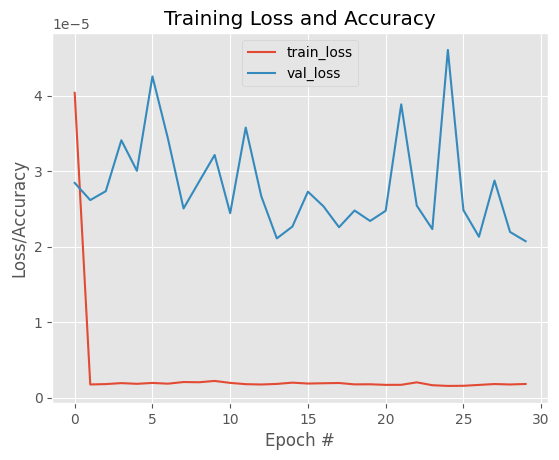

In [245]:
epochs=30
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
#plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
#plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()


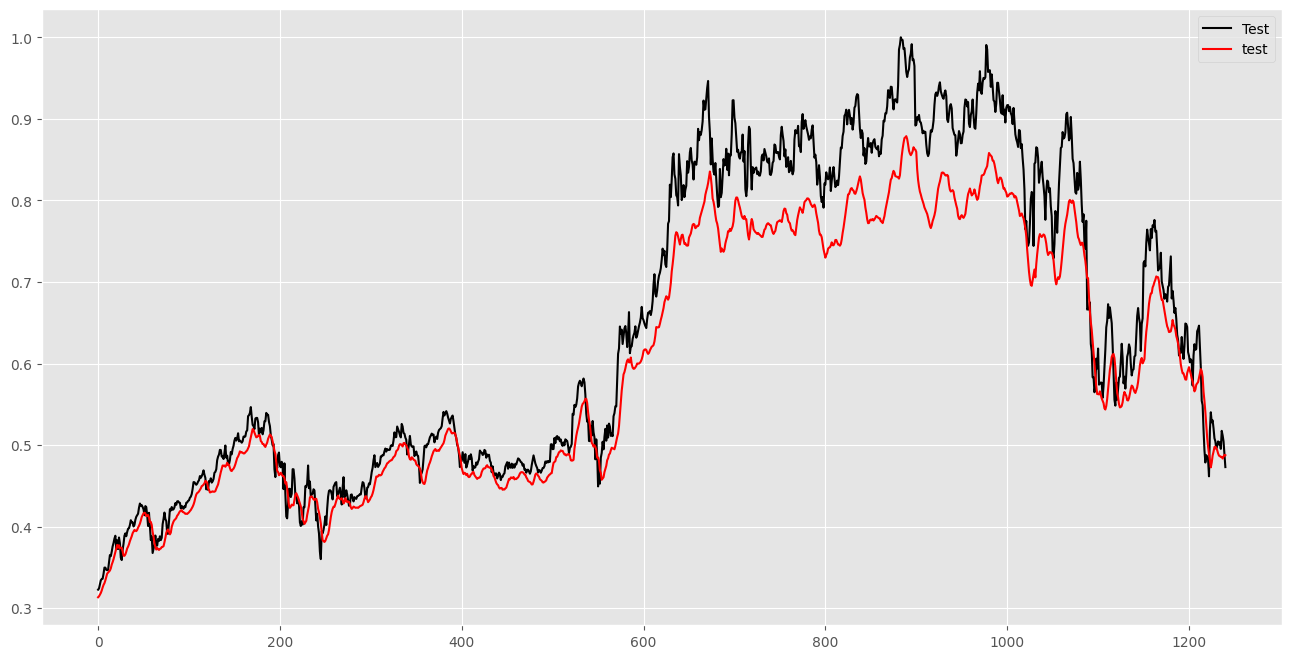

In [246]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

Overall this LSTM is not too bad, but its not perfect either as it is always undershooting what the real black line is at. At this point I was still convinced that LSTM was the best model to use as that is what all of the online sources that I read were using. To prove this the next model I used is a bidirectional rnn

In [247]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(Bidirectional(SimpleRNN(150, name="layer1")))
model.add(Dense(1))
model.add(Activation('linear'))

In [248]:
opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 300)              47700     
 nal)                                                            
                                                                 
 dense_22 (Dense)            (None, 1)                 301       
                                                                 
 activation_22 (Activation)  (None, 1)                 0         
                                                                 
Total params: 48,001
Trainable params: 48,001
Non-trainable params: 0
_________________________________________________________________


In [249]:
H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

Epoch 1/30
249/249 [==============================] - 3s 7ms/step - loss: 0.0138 - accuracy: 0.0000e+00 - val_loss: 4.9776e-04 - val_accuracy: 0.0000e+00
Epoch 2/30
249/249 [==============================] - 1s 6ms/step - loss: 2.8415e-05 - accuracy: 0.0000e+00 - val_loss: 3.1704e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
249/249 [==============================] - 1s 6ms/step - loss: 1.4183e-05 - accuracy: 0.0000e+00 - val_loss: 2.3941e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
249/249 [==============================] - 1s 6ms/step - loss: 1.3649e-05 - accuracy: 0.0000e+00 - val_loss: 2.3458e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
249/249 [==============================] - 1s 6ms/step - loss: 1.2366e-05 - accuracy: 0.0000e+00 - val_loss: 2.2318e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
249/249 [==============================] - 2s 6ms/step - loss: 1.0823e-05 - accuracy: 0.0000e+00 - val_loss: 1.5023e-04 - val_accuracy: 0.0000e+00
Epoch 7/30
249/249 [==============================] - 1s

In [250]:
y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

39/39 [==============================] - 0s 2ms/step
[57.634663] [60.20999908]
[56.8728] [60.47949982]
[57.48473] [61.45700073]
[58.067787] [62.34349823]
[58.354183] [62.63499832]
[58.883278] [62.71649933]
[59.838665] [63.83399963]
[60.507652] [65.26000214]
[59.976814] [65.24299622]
[60.978203] [64.75]
[61.83821] [64.66600037]
[61.848953] [64.72899628]
[61.00279] [66.3655014]
[61.23468] [68.1269989]
[61.88851] [67.87550354]
[62.83431] [68.89749908]
[63.90228] [70.10250092]
[64.176636] [70.88400269]
[65.0439] [71.89099884]
[65.53748] [72.54450226]
[66.59216] [69.5]
[67.24136] [71.49749756]
[68.56629] [69.5]
[67.15071] [72.14199829]
[67.82213] [70.83899689]
[65.87306] [67.52500153]
[67.46968] [66.98000336]
[67.219734] [69.31150055]
[65.74519] [70.72550201]
[64.26871] [72.55249786]
[66.1337] [73.08799744]
[68.040726] [72.43450165]
[68.359116] [73.41750336]
[69.67565] [74.14600372]
[69.668434] [74.26699829]
[70.34458] [75.]
[70.98508] [76.09750366]
[71.11194] [75.59899902]
[71.29825] [75.6

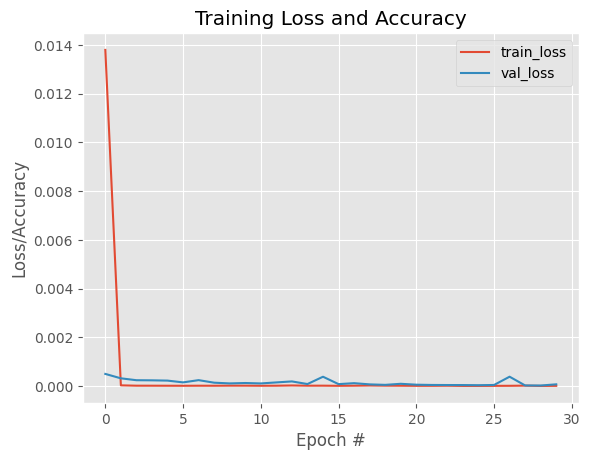

In [251]:
epochs=30
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
#plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
#plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()


Surpisingly This model worked signifigantly better than the LSTM did. With a 5 percent increase in over all accuracy to the real world data. The loss function also looks much better as while it has a few spikes it does converge with the training loss. 

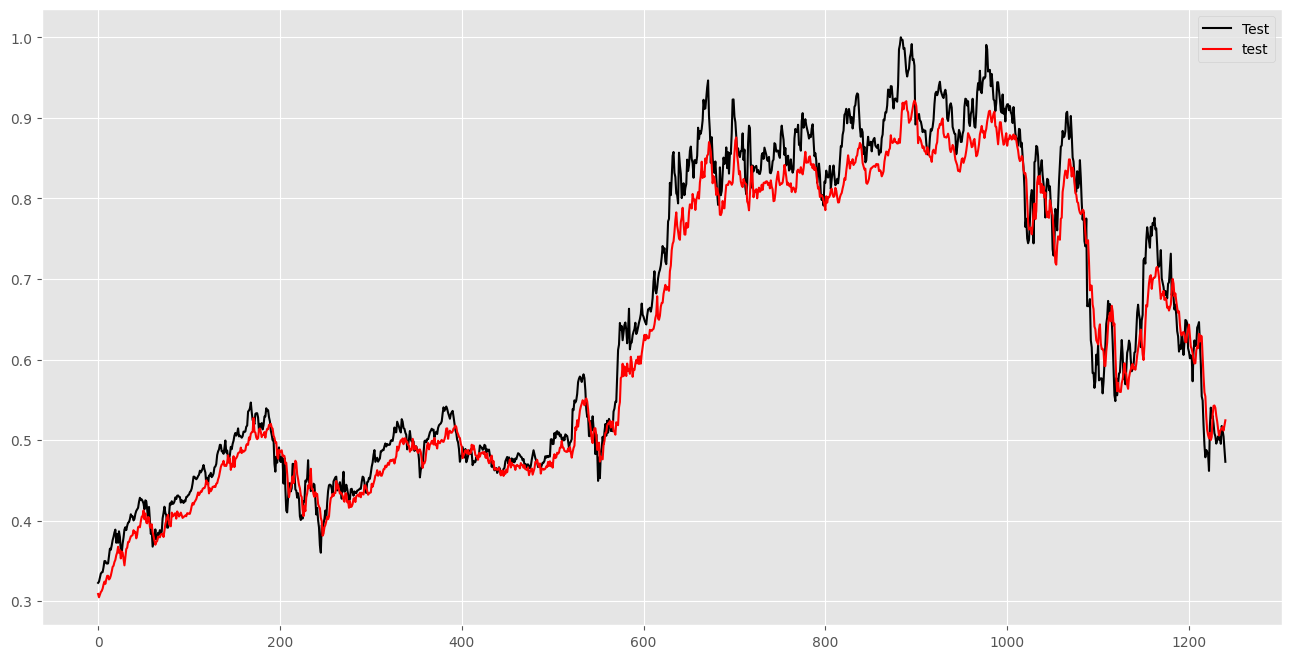

In [252]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

As we can see here even the overall grapd is better for this model as it is much tighter to the orginal data. With this in mind The next model I chose to expirament with was a basic RNN model.

In [253]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(SimpleRNN(150, name="layer1"))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (SimpleRNN)          (None, 150)               23850     
                                                                 
 dense_23 (Dense)            (None, 1)                 151       
                                                                 
 activation_23 (Activation)  (None, 1)                 0         
                                                                 
Total params: 24,001
Trainable params: 24,001
Non-trainable params: 0
_________________________________________________________________


In [254]:
H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

Epoch 1/30
249/249 [==============================] - 2s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 2/30
249/249 [==============================] - 1s 4ms/step - loss: 1.4522e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 3/30
249/249 [==============================] - 1s 4ms/step - loss: 7.5377e-06 - accuracy: 0.0000e+00 - val_loss: 4.4799e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
249/249 [==============================] - 1s 4ms/step - loss: 6.6354e-06 - accuracy: 0.0000e+00 - val_loss: 2.7141e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
249/249 [==============================] - 1s 4ms/step - loss: 9.9779e-06 - accuracy: 0.0000e+00 - val_loss: 5.4580e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
249/249 [==============================] - 1s 4ms/step - loss: 8.5799e-06 - accuracy: 0.0000e+00 - val_loss: 8.1734e-05 - val_accuracy: 0.0000e+00
Epoch 7/30
249/249 [==============================] - 1s 4ms/ste

In [255]:
y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

39/39 [==============================] - 0s 2ms/step
[59.978813] [60.20999908]
[60.3552] [60.47949982]
[60.604088] [61.45700073]
[61.037098] [62.34349823]
[61.91948] [62.63499832]
[62.753662] [62.71649933]
[62.73943] [63.83399963]
[63.177074] [65.26000214]
[63.756668] [65.24299622]
[64.46191] [64.75]
[65.99441] [64.66600037]
[65.983864] [64.72899628]
[64.80344] [66.3655014]
[65.24957] [68.1269989]
[65.908905] [67.87550354]
[67.25017] [68.89749908]
[68.63866] [70.10250092]
[68.25211] [70.88400269]
[69.17217] [71.89099884]
[70.41914] [72.54450226]
[70.74936] [69.5]
[72.092285] [71.49749756]
[71.218895] [69.5]
[72.041336] [72.14199829]
[71.83905] [70.83899689]
[69.97682] [67.52500153]
[71.544716] [66.98000336]
[70.63105] [69.31150055]
[68.69371] [70.72550201]
[68.71249] [72.55249786]
[69.40832] [73.08799744]
[71.49733] [72.43450165]
[73.54519] [73.41750336]
[71.804474] [74.14600372]
[72.69909] [74.26699829]
[74.42656] [75.]
[73.947174] [76.09750366]
[73.99666] [75.59899902]
[74.69388] [75

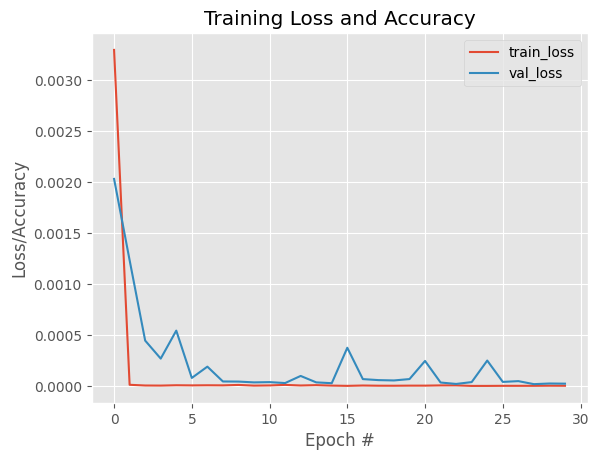

In [256]:
epochs=30
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
#plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
#plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

Unsuprisingly this model was worse than its bidirectional counterpart. but it is still much better than the LSTM Model, thus proving that the LSTM is not a good predictor for this model. In addition to that both the bidirectional model and the simple rnn are both faster than LSTM is. LSTM is just more than twice as slow as the RNN and Bidirectional DRNN models are. The lstm took 1m and 16 sec while the RNN took 30 seconds and the bidirectional took 40 seconds.

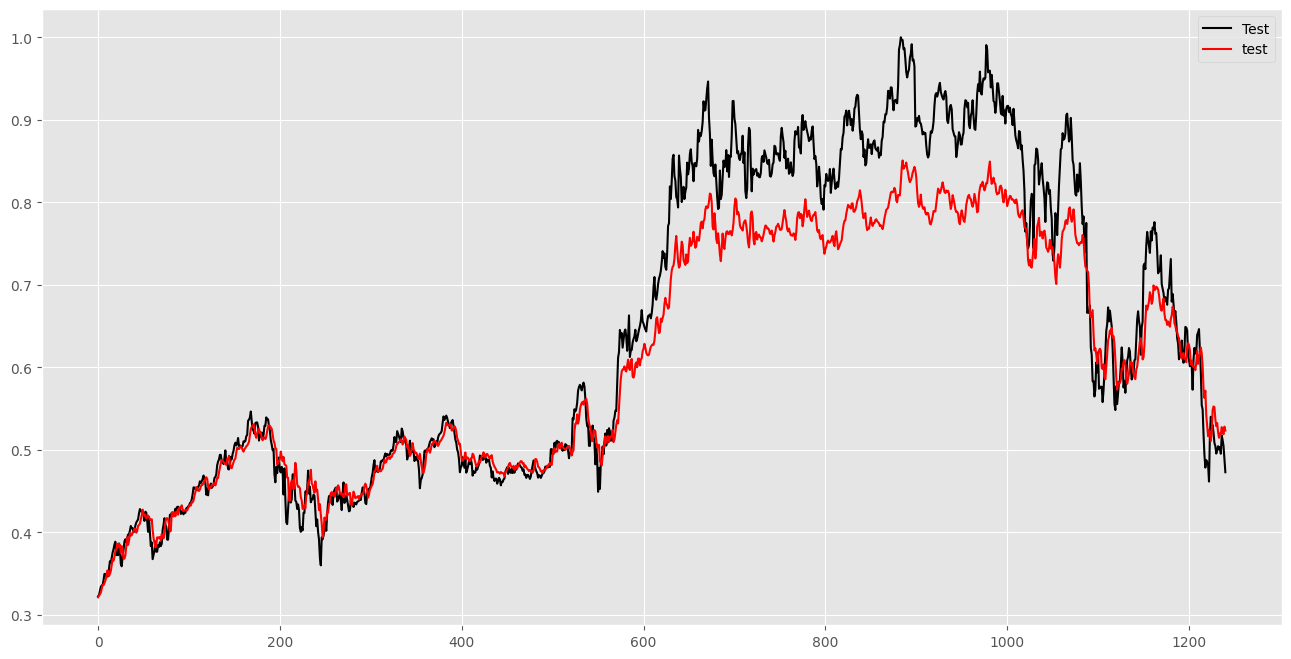

In [257]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

As we can see we get a similar graph as to the bidirectional data. The last model I chose to look at whas the GRU model.

In [258]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(tf.keras.layers.GRU(150, name="layer1"))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 150)               72000     
                                                                 
 dense_24 (Dense)            (None, 1)                 151       
                                                                 
 activation_24 (Activation)  (None, 1)                 0         
                                                                 
Total params: 72,151
Trainable params: 72,151
Non-trainable params: 0
_________________________________________________________________


In [259]:
H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

Epoch 1/30
249/249 [==============================] - 4s 12ms/step - loss: 6.2932e-05 - accuracy: 0.0000e+00 - val_loss: 5.2321e-05 - val_accuracy: 0.0000e+00
Epoch 2/30
249/249 [==============================] - 3s 11ms/step - loss: 2.0983e-06 - accuracy: 0.0000e+00 - val_loss: 2.5695e-05 - val_accuracy: 0.0000e+00
Epoch 3/30
249/249 [==============================] - 3s 11ms/step - loss: 2.2047e-06 - accuracy: 0.0000e+00 - val_loss: 2.3254e-05 - val_accuracy: 0.0000e+00
Epoch 4/30
249/249 [==============================] - 3s 11ms/step - loss: 2.5116e-06 - accuracy: 0.0000e+00 - val_loss: 2.6832e-05 - val_accuracy: 0.0000e+00
Epoch 5/30
249/249 [==============================] - 3s 11ms/step - loss: 2.4771e-06 - accuracy: 0.0000e+00 - val_loss: 2.2559e-05 - val_accuracy: 0.0000e+00
Epoch 6/30
249/249 [==============================] - 3s 11ms/step - loss: 4.0156e-06 - accuracy: 0.0000e+00 - val_loss: 2.9028e-05 - val_accuracy: 0.0000e+00
Epoch 7/30
249/249 [==========================

In [263]:
y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

39/39 [==============================] - 0s 4ms/step
[59.338856] [60.20999908]
[59.9379] [60.47949982]
[60.732212] [61.45700073]
[61.234417] [62.34349823]
[61.972805] [62.63499832]
[62.877266] [62.71649933]
[63.342777] [63.83399963]
[63.20547] [65.26000214]
[64.1182] [65.24299622]
[65.18045] [64.75]
[66.09876] [64.66600037]
[65.43328] [64.72899628]
[65.2113] [66.3655014]
[65.60533] [68.1269989]
[66.345726] [67.87550354]
[68.020096] [68.89749908]
[68.48305] [70.10250092]
[68.991875] [70.88400269]
[70.068146] [71.89099884]
[70.97588] [72.54450226]
[71.35584] [69.5]
[72.816895] [71.49749756]
[70.37529] [69.5]
[72.24063] [72.14199829]
[69.69963] [70.83899689]
[70.52457] [67.52500153]
[71.485794] [66.98000336]
[69.38459] [69.31150055]
[67.6804] [70.72550201]
[69.18941] [72.55249786]
[70.546135] [73.08799744]
[71.919106] [72.43450165]
[73.185646] [73.41750336]
[72.963646] [74.14600372]
[73.445244] [74.26699829]
[74.515724] [75.]
[74.73411] [76.09750366]
[75.13111] [75.59899902]
[76.05323] [7

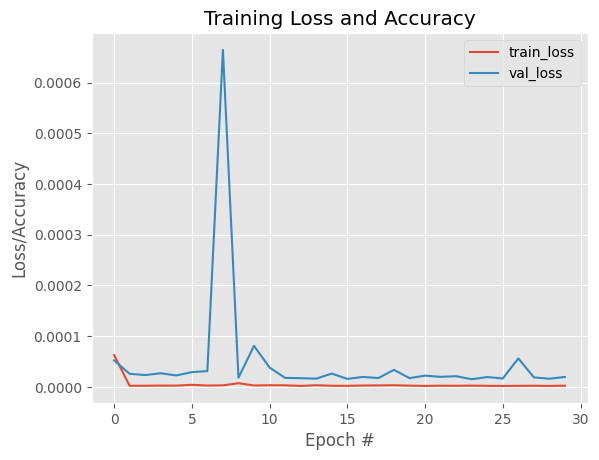

In [261]:
epochs=30
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
#plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
#plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

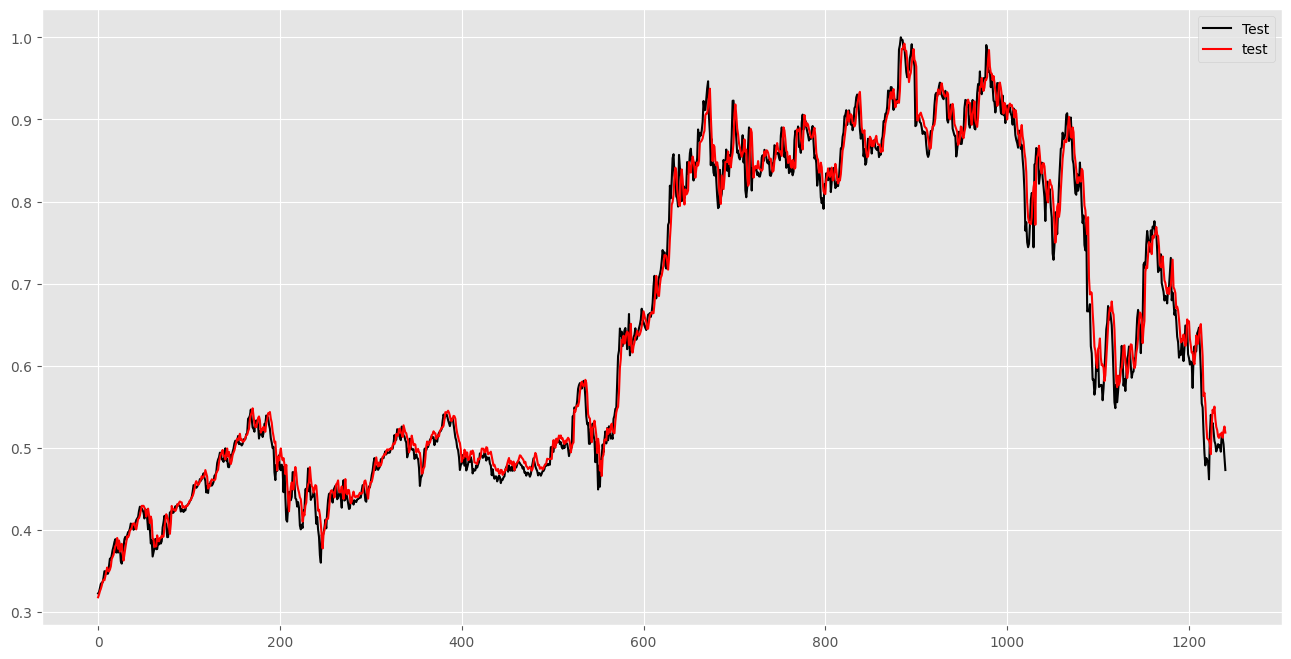

In [262]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

Suprisingly GRU did the best on this data. Althought looking back on it, GRU being much better does make sense. In general LSTM is used for longer sequences, which this is not actually to long. Plus Lstm works better on lage datasets which what I am working with is not a large dataset at all. However all of these metrics we looked are not actually all the useful in the real world. If we look closer at what is actutually happening in the graphs we see that the predicted data is really just lagging behind the orginal data. While this is great for repoducing what might happen it does not actually translate into real values all that well. The next section of the project shows this fact in more detail.

In [264]:
numpy_scaled = df_max_scaled.to_numpy()

x_data =[]

numDays = 30 #this is the number of days feed in before a prediction

print(numpy_scaled.shape)
for x in range(8): #want to keep the first 8 columns for the data
    x_data.append([])
    for y in range(numDays, numpy_scaled.shape[0]):
        x_data[x].append(numpy_scaled[y-numDays:y,x])

x_data = np.moveaxis(x_data, [0],[2])
#grab the change data
x_data, y = np.array(x_data), np.array(numpy_scaled[numDays:,-3])
y=np.reshape(y,(len(y),1))
print(x_data.shape,"\n",y.shape)

trainX, valX, testX = x_data[:big], x_data[big:(big+half)], x_data[(big+half):]
trainY, valY, testY = y[:big], y[big:(big+half)], y[(big+half):]

print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)



(6234, 11)
(6204, 30, 8) 
 (6204, 1)
(3722, 30, 8) (1241, 30, 8) (1241, 30, 8)
(3722, 1) (1241, 1) (1241, 1)


In [265]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(LSTM(150, name="layer1"))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 150)               95400     
                                                                 
 dense_25 (Dense)            (None, 1)                 151       
                                                                 
 activation_25 (Activation)  (None, 1)                 0         
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [266]:
H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

Epoch 1/30
249/249 [==============================] - 8s 23ms/step - loss: 1.0180e-04 - accuracy: 0.0064 - val_loss: 0.0010 - val_accuracy: 0.0016
Epoch 2/30
249/249 [==============================] - 5s 20ms/step - loss: 9.8548e-05 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 3/30
249/249 [==============================] - 5s 21ms/step - loss: 9.9795e-05 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 4/30
249/249 [==============================] - 5s 20ms/step - loss: 9.7688e-05 - accuracy: 0.0064 - val_loss: 0.0013 - val_accuracy: 0.0016
Epoch 5/30
249/249 [==============================] - 5s 20ms/step - loss: 9.8062e-05 - accuracy: 0.0064 - val_loss: 0.0010 - val_accuracy: 0.0016
Epoch 6/30
249/249 [==============================] - 5s 20ms/step - loss: 1.0217e-04 - accuracy: 0.0064 - val_loss: 0.0010 - val_accuracy: 0.0016
Epoch 7/30
249/249 [==============================] - 5s 20ms/step - loss: 9.9556e-05 - accuracy: 0.0064 - val_loss: 0

/tmp/ipykernel_7368/1621899311.py:9: RuntimeWarning: divide by zero encountered in divide
  acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


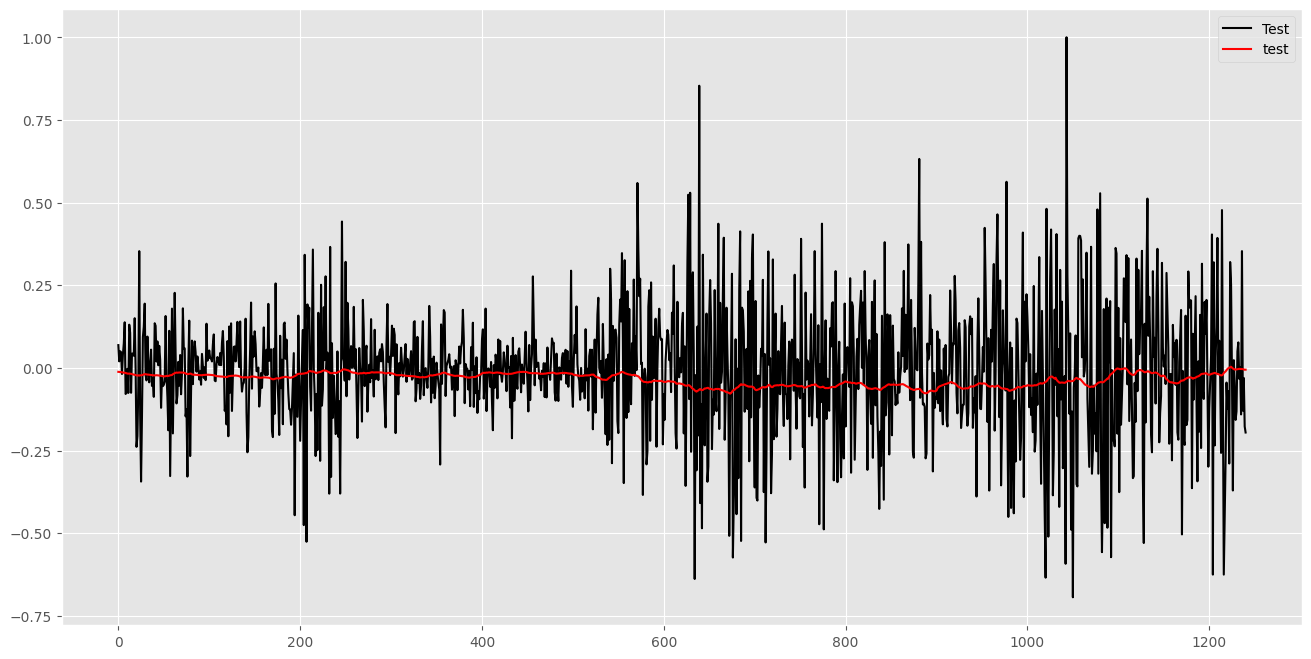

In [267]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

Here we ran the LSTM model again, but instead of predicting tommorows adjusted closing price, we instread predicted what the change would be. As we can see by this graph the actually change in the numbers is very erratic and not smooth at all. In direct contrast to that is the predicted balues which do not show how dramatic the changes really are. This clearly shows that this model is not all too useful in future prediction of the data. Next we will examine the other models again predicting the change in price to see if the other models are any better.

In [269]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(Bidirectional(SimpleRNN(150, name="layer1")))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 300)              47700     
 nal)                                                            
                                                                 
 dense_27 (Dense)            (None, 1)                 301       
                                                                 
 activation_27 (Activation)  (None, 1)                 0         
                                                                 
Total params: 48,001
Trainable params: 48,001
Non-trainable params: 0
_________________________________________________________________


In [270]:

H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

Epoch 1/30
249/249 [==============================] - 5s 13ms/step - loss: 0.0071 - accuracy: 0.0064 - val_loss: 0.0022 - val_accuracy: 0.0016
Epoch 2/30
249/249 [==============================] - 3s 11ms/step - loss: 1.2877e-04 - accuracy: 0.0064 - val_loss: 0.0031 - val_accuracy: 0.0016
Epoch 3/30
249/249 [==============================] - 3s 11ms/step - loss: 1.5045e-04 - accuracy: 0.0064 - val_loss: 0.0019 - val_accuracy: 0.0016
Epoch 4/30
249/249 [==============================] - 3s 12ms/step - loss: 2.1457e-04 - accuracy: 0.0064 - val_loss: 0.0014 - val_accuracy: 0.0016
Epoch 5/30
249/249 [==============================] - 3s 11ms/step - loss: 1.4756e-04 - accuracy: 0.0064 - val_loss: 0.0019 - val_accuracy: 0.0016
Epoch 6/30
249/249 [==============================] - 3s 12ms/step - loss: 1.3810e-04 - accuracy: 0.0064 - val_loss: 0.0012 - val_accuracy: 0.0016
Epoch 7/30
249/249 [==============================] - 3s 12ms/step - loss: 1.2467e-04 - accuracy: 0.0064 - val_loss: 0.001

/tmp/ipykernel_7368/440278108.py:9: RuntimeWarning: divide by zero encountered in divide
  acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


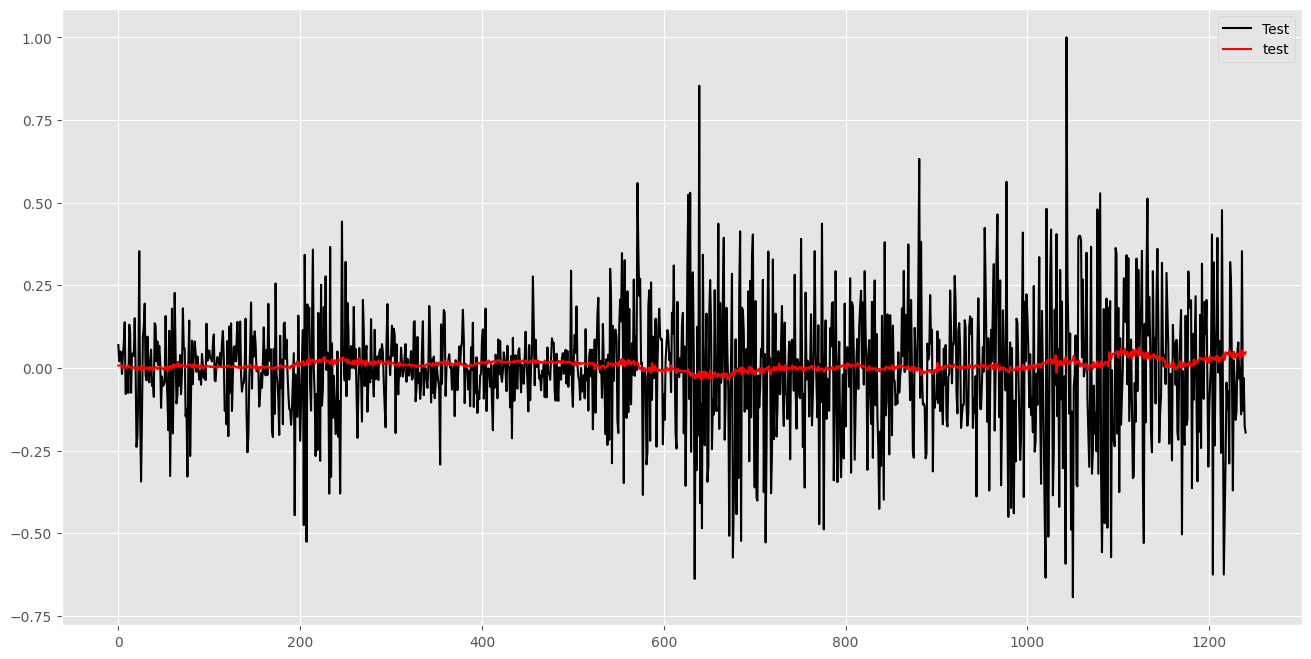

In [271]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

This was the bidirectional rnn and this is a much better prediction but it still is not a good one. This prediction at least shows some of the peaks while following the general trend. It is still a bad predictor over all. 

In [272]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(SimpleRNN(150, name="layer1"))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (SimpleRNN)          (None, 150)               23850     
                                                                 
 dense_28 (Dense)            (None, 1)                 151       
                                                                 
 activation_28 (Activation)  (None, 1)                 0         
                                                                 
Total params: 24,001
Trainable params: 24,001
Non-trainable params: 0
_________________________________________________________________


In [273]:

H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

Epoch 1/30
249/249 [==============================] - 4s 10ms/step - loss: 0.0049 - accuracy: 0.0064 - val_loss: 0.0013 - val_accuracy: 0.0016
Epoch 2/30
249/249 [==============================] - 2s 9ms/step - loss: 1.4406e-04 - accuracy: 0.0064 - val_loss: 0.0012 - val_accuracy: 0.0016
Epoch 3/30
249/249 [==============================] - 2s 9ms/step - loss: 1.6707e-04 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 4/30
249/249 [==============================] - 2s 9ms/step - loss: 1.5437e-04 - accuracy: 0.0064 - val_loss: 0.0018 - val_accuracy: 0.0016
Epoch 5/30
249/249 [==============================] - 2s 9ms/step - loss: 1.3695e-04 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 6/30
249/249 [==============================] - 2s 9ms/step - loss: 1.2663e-04 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 7/30
249/249 [==============================] - 2s 9ms/step - loss: 1.4694e-04 - accuracy: 0.0064 - val_loss: 0.0012 - va

/tmp/ipykernel_7368/440278108.py:9: RuntimeWarning: divide by zero encountered in divide
  acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


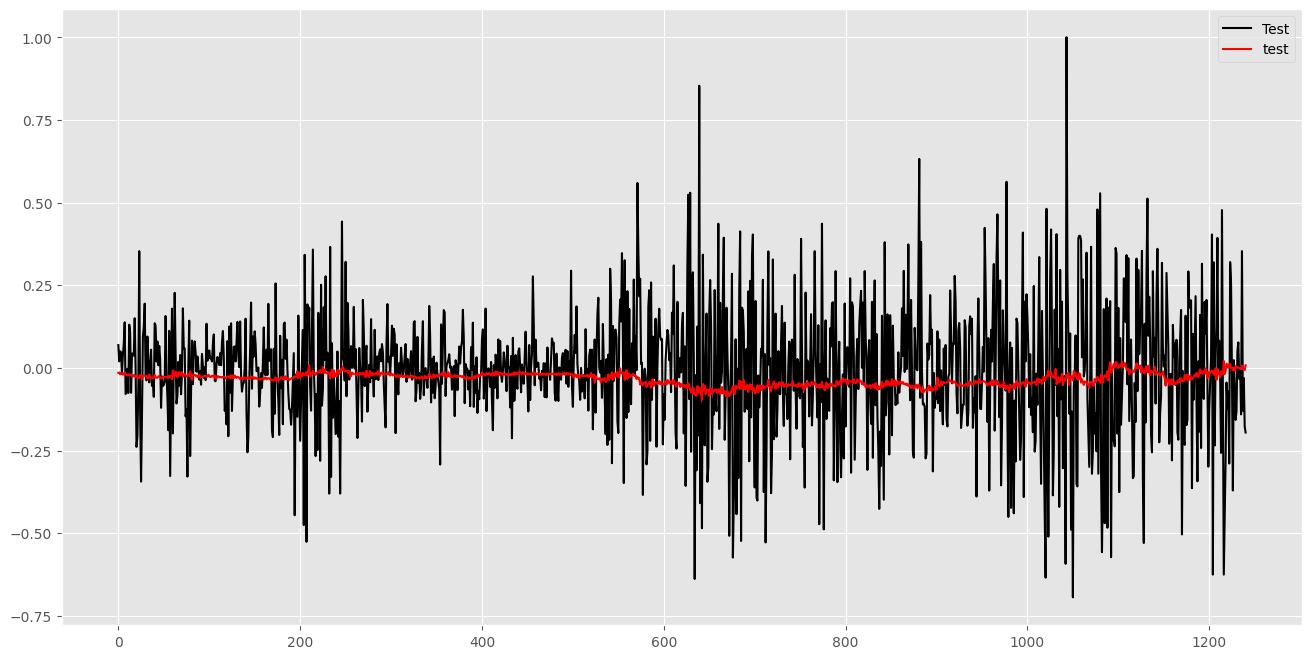

In [274]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

This model is the simple rnn and is giving the same result as the bidirectional rnn did, just as last time while it has the peaks it still does not show anywhere close to the actual;y change that happens.

In [275]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(tf.keras.layers.GRU(150, name="layer1"))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 150)               72000     
                                                                 
 dense_29 (Dense)            (None, 1)                 151       
                                                                 
 activation_29 (Activation)  (None, 1)                 0         
                                                                 
Total params: 72,151
Trainable params: 72,151
Non-trainable params: 0
_________________________________________________________________


In [276]:

H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

Epoch 1/30
249/249 [==============================] - 9s 25ms/step - loss: 1.5339e-04 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 2/30
249/249 [==============================] - 6s 22ms/step - loss: 1.1795e-04 - accuracy: 0.0064 - val_loss: 0.0012 - val_accuracy: 0.0016
Epoch 3/30
249/249 [==============================] - 5s 22ms/step - loss: 1.1502e-04 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 4/30
249/249 [==============================] - 6s 23ms/step - loss: 1.1564e-04 - accuracy: 0.0064 - val_loss: 0.0010 - val_accuracy: 0.0016
Epoch 5/30
249/249 [==============================] - 5s 22ms/step - loss: 1.0780e-04 - accuracy: 0.0064 - val_loss: 0.0012 - val_accuracy: 0.0016
Epoch 6/30
249/249 [==============================] - 5s 22ms/step - loss: 1.0514e-04 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 7/30
249/249 [==============================] - 5s 22ms/step - loss: 1.0176e-04 - accuracy: 0.0064 - val_loss: 0

/tmp/ipykernel_7368/440278108.py:9: RuntimeWarning: divide by zero encountered in divide
  acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


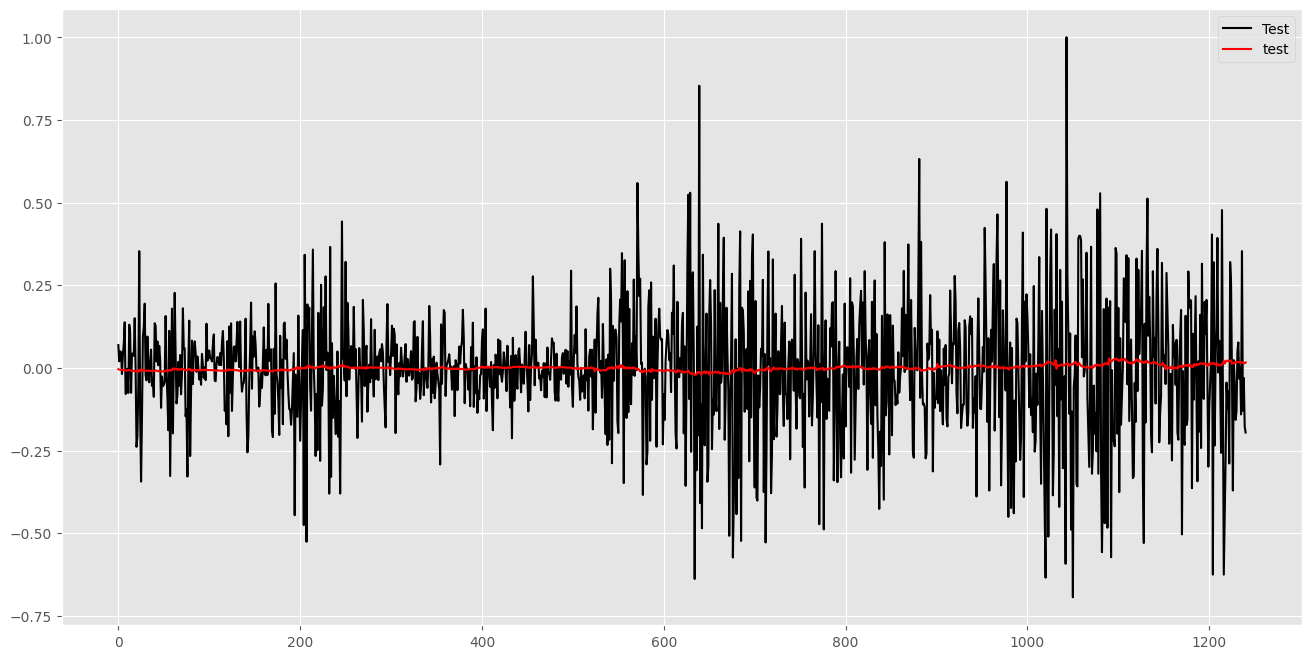

In [277]:
plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

Interestingly enough the GRU is not the best model for this as it is clearly beaten by the bidrectyional rnn and the simple rnn. It is however still better than lstm as it has more peak information. Being the bidirectional rnn seems to be the best for this model Lets try making it twice as deep and see if there is any notiable difference.

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirecti  (None, 600)              185400    
 onal)                                                           
                                                                 
 dense_31 (Dense)            (None, 1)                 601       
                                                                 
 activation_31 (Activation)  (None, 1)                 0         
                                                                 
Total params: 186,001
Trainable params: 186,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
249/249 [==============================] - 5s 10ms/step - loss: 0.0267 - accuracy: 0.0064 - val_loss: 0.0011 - val_accuracy: 0.0016
Epoch 2/30
249/249 [==============================] - 2s 9ms/step - loss: 1.4252e-04 - accuracy: 0.006

/tmp/ipykernel_7368/1241102316.py:22: RuntimeWarning: divide by zero encountered in divide
  acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


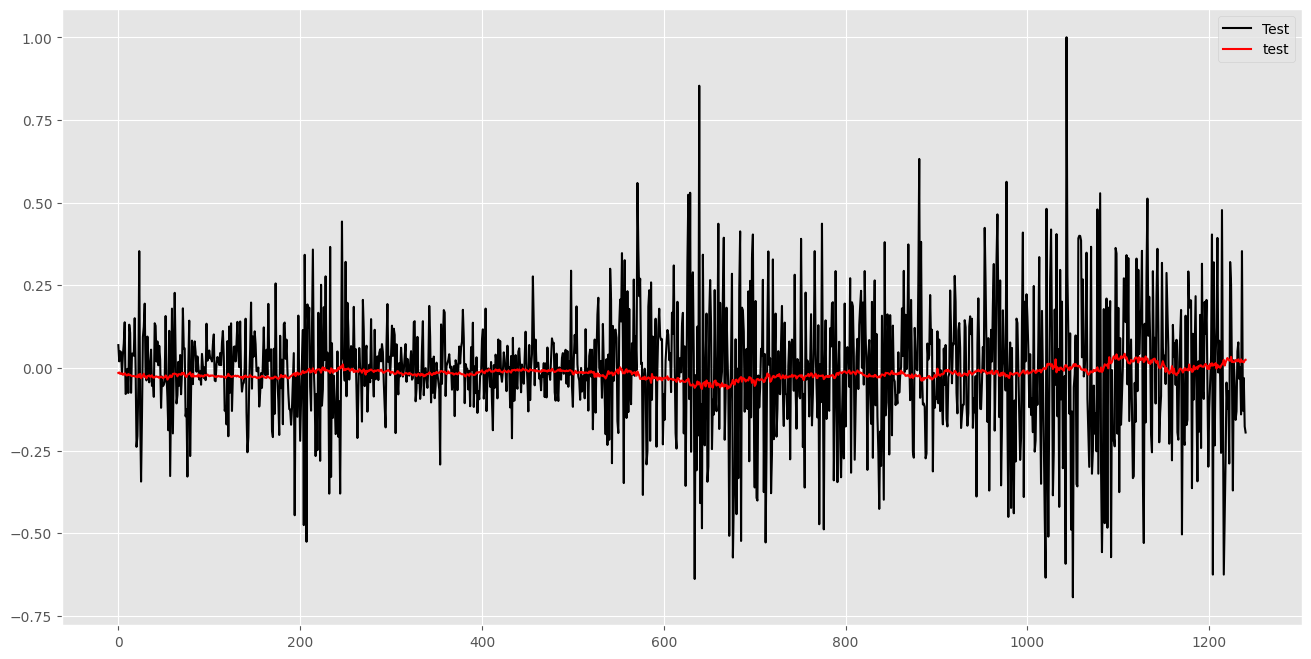

In [281]:
model = Sequential()
model.add(Input(shape=(numDays,8)))
model.add(Bidirectional(SimpleRNN(300, name="layer1")))
model.add(Dense(1))
model.add(Activation('linear'))

opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
model.summary()


H = model.fit(x=trainX,y=trainY,batch_size=15,epochs=30, validation_data=(valX, valY))

y_pred = model.predict(testX)

for i in range(150):

    print(y_pred[i]*conversionMax, testY[i]*conversionMax)

acc=(((np.absolute(y_pred-testY)*conversionMax)/(np.absolute(testY)*conversionMax))*100)


avgAcc=np.average(acc)
print("Accuracy: ", 100-avgAcc)

plt.figure(figsize=(16,8))
plt.plot(testY, color="black", label = 'Test')
plt.plot(y_pred, color = 'red', label = 'test')
plt.legend()
plt.show()

The result of that last test showed that the density of the model does not really matter all to much, as it is still a bad prediction of the data. The onyl real way That I can think of to make this model any better would be to add more data that shows the movement of the data.